## Import the neccessary libraries for this project.

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns


print("All libraries have been imported!")

All libraries have been imported!


## Print the version of the dependencies.

In [2]:
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
import matplotlib
print(f"matplotlib version: {matplotlib.__version__}")

import scipy
print(f"scipy version: {scipy.__version__}")

import warnings
warnings.filterwarnings("ignore")

numpy version: 1.26.4
pandas version: 2.2.2
matplotlib version: 3.7.1
scipy version: 1.13.1


## MODEL BUILDING

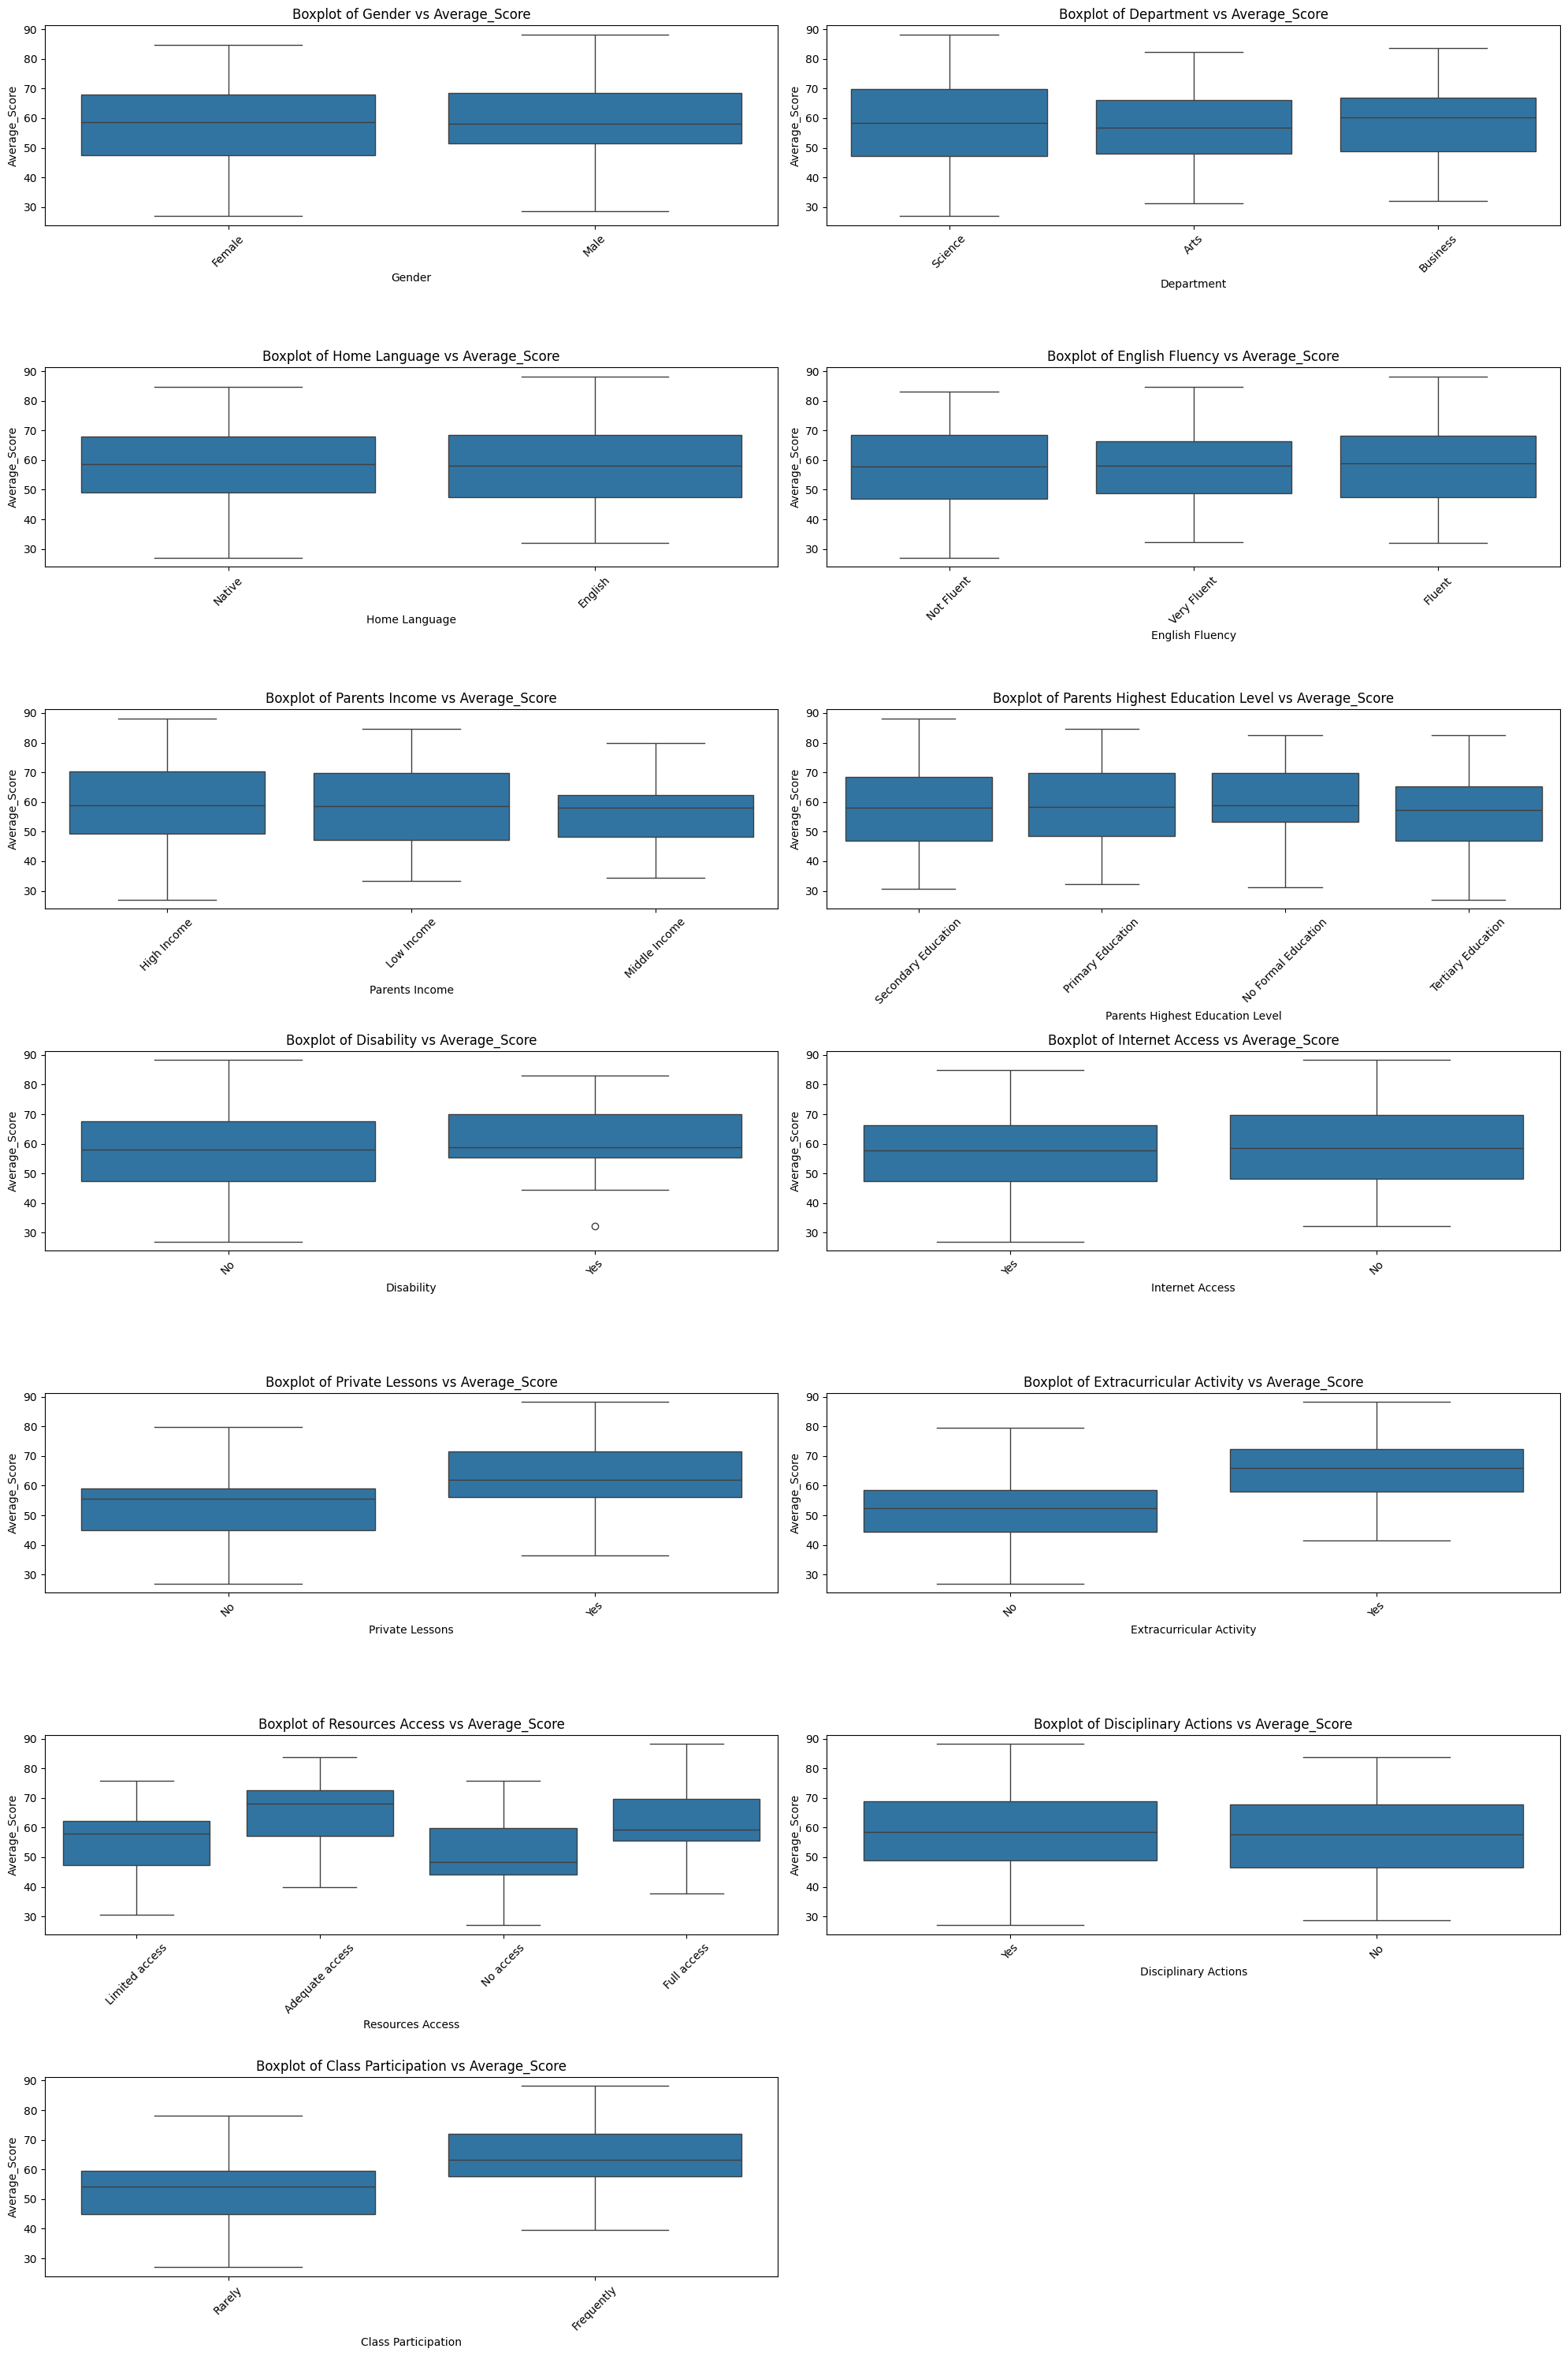

In [51]:
# Get the Categorical columns.
categorical_columns = [
    'Gender', 'Department', 'Home Language', 'English Fluency',
    'Parents Income', 'Parents Highest Education Level', 'Disability', 'Internet Access',
    'Private Lessons', 'Extracurricular Activity', 'Resources Access',
    'Disciplinary Actions', 'Class Participation'
]

# Set up the figure and axis.
plt.figure(figsize=(20, 30))

# Loop through each categorical column to create boxplots.
for i, column in enumerate(categorical_columns):
    plt.subplot(len(categorical_columns)//2 + 1, 2, i+1)
    sns.boxplot(x=column, y='Average_Score', data=student_data_df)
    plt.title(f'Boxplot of {column} vs Average_Score')
    plt.xticks(rotation=45)

# Adjust layout.
plt.tight_layout()
plt.show()

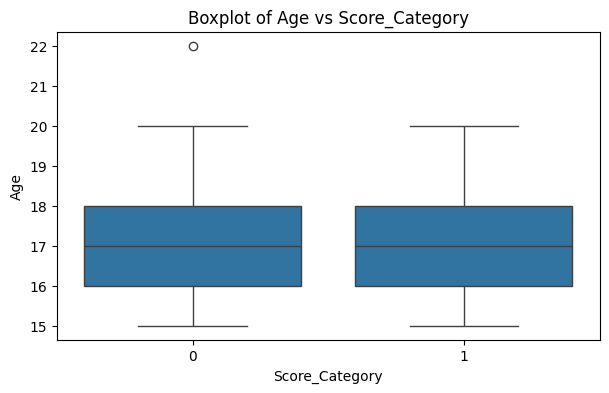

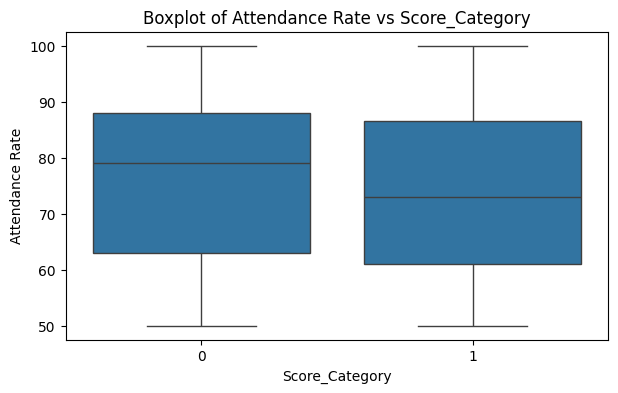

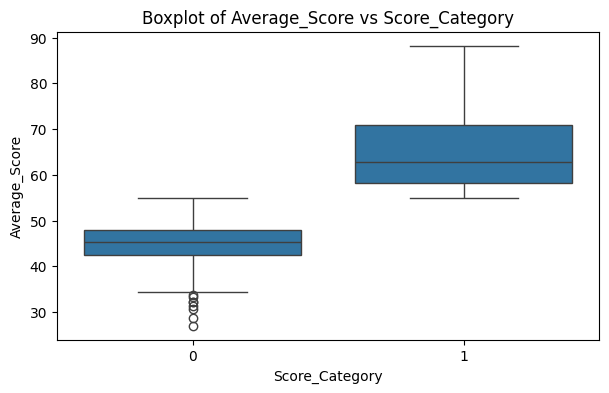

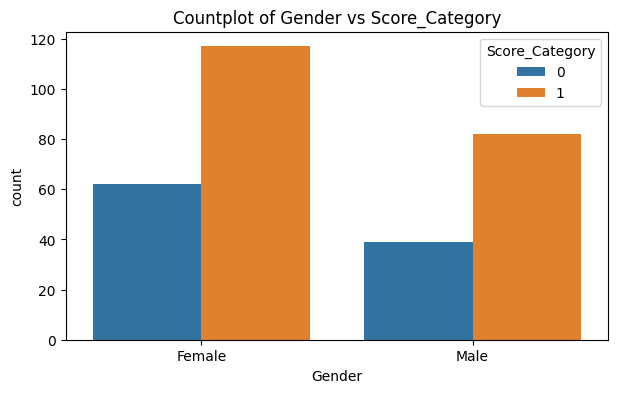

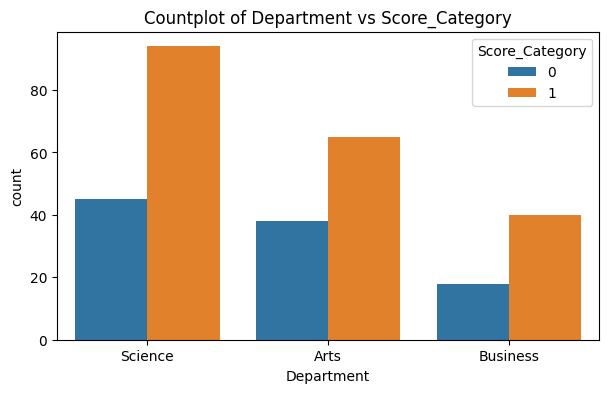

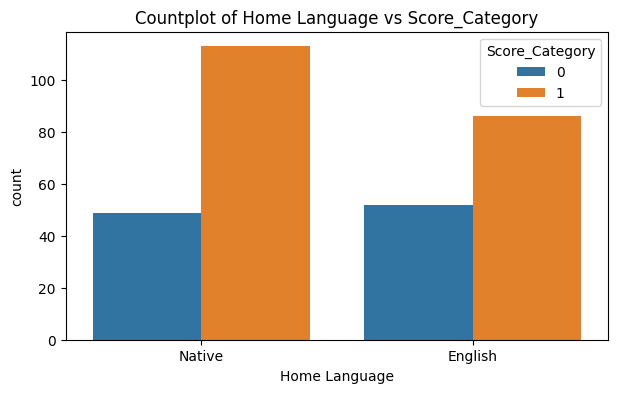

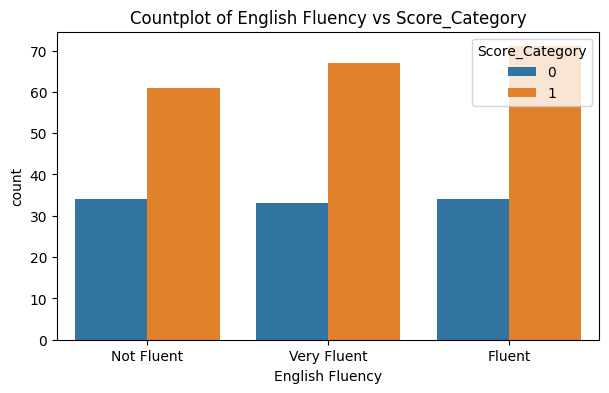

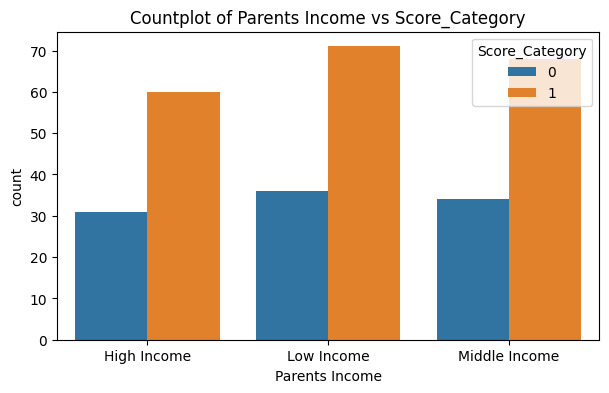

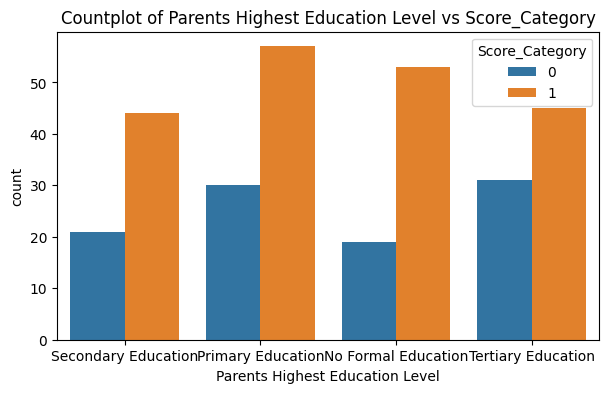

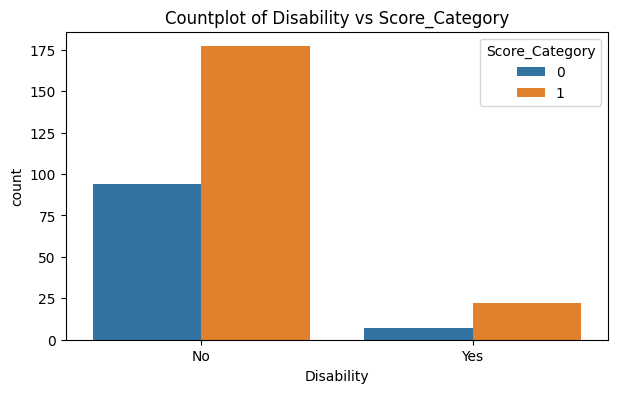

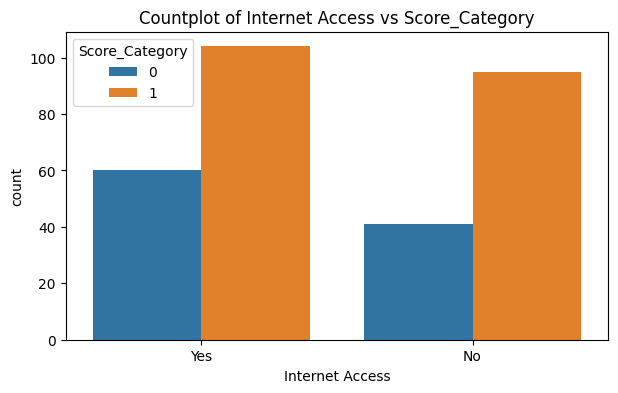

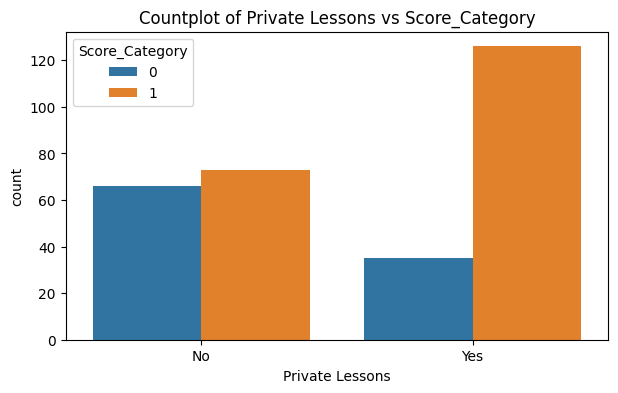

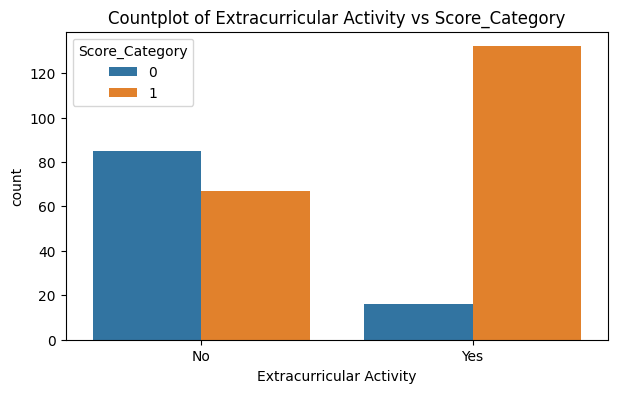

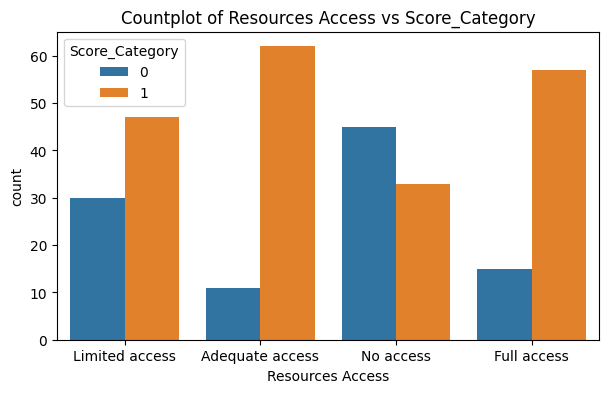

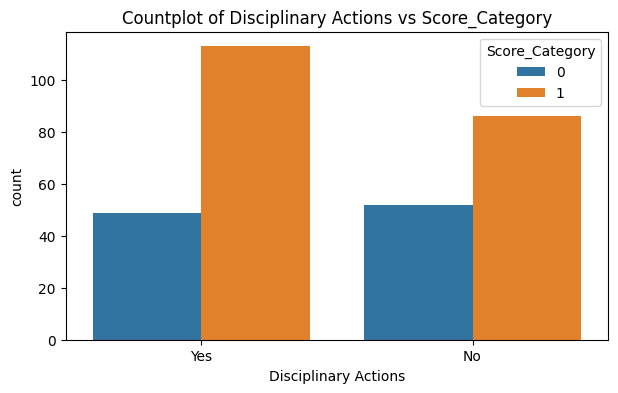

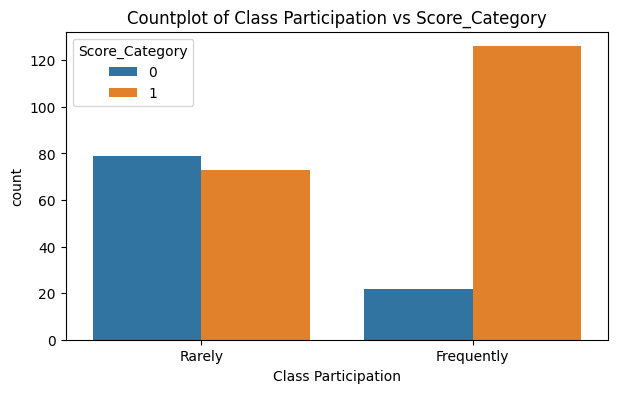

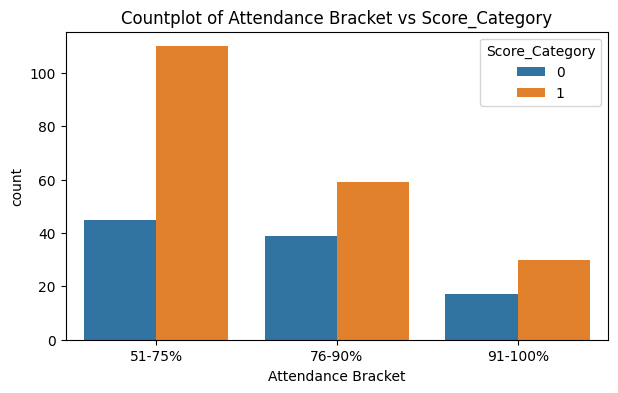

In [60]:
# Identify categorical and numerical columns.
numerical_columns = student_data_df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = student_data_df.select_dtypes(include=['object', 'category']).columns

# Define a fixed figure size.
fig_width, fig_height = 7, 4

# Plot numerical variables against Score_Category.
for column in numerical_columns:
    if column != 'Score_Category':
        if column == "student_id":
            continue
        plt.figure(figsize=(fig_width, fig_height))
        sns.boxplot(x='Score_Category', y=column, data=student_data_df)
        plt.title(f'Boxplot of {column} vs Score_Category')
        plt.show()


# Plot categorical variables against Score_Category.
for column in categorical_columns:
    plt.figure(figsize=(fig_width, fig_height))
    sns.countplot(x=column, hue='Score_Category', data=student_data_df)
    plt.title(f'Countplot of {column} vs Score_Category')
    plt.show()

In [61]:
features = student_data_df.drop(["student_id", "Average_Score", "Score_Category", "Attendance Rate"], axis=1)

target = student_data_df[["Score_Category"]]

In [ ]:
features.head()

,Age,Gender,Department,Home Language,English Fluency,Parents Income,Parents Highest Education Level,Disability,Internet Access,Private Lessons,Extracurricular Activity,Resources Access,Disciplinary Actions,Class Participation,Attendance Bracket
0,18,Female,Science,Native,Not Fluent,High Income,Secondary Education,No,Yes,No,No,Limited access,Yes,Rarely,51-75%
1,18,Male,Science,English,Not Fluent,Low Income,Primary Education,No,Yes,No,No,Adequate access,No,Frequently,76-90%
2,17,Female,Science,Native,Very Fluent,Middle Income,Secondary Education,No,No,Yes,No,Limited access,Yes,Frequently,51-75%
3,19,Female,Science,Native,Fluent,Low Income,Secondary Education,No,Yes,Yes,No,No access,Yes,Rarely,51-75%
4,18,Male,Science,English,Very Fluent,Low Income,No Formal Education,No,No,Yes,Yes,Limited access,Yes,Frequently,51-75%


In [62]:
categorical_features_indices = np.where(features.dtypes != int)[0]

In [63]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline

### Data Splitting
Let's split the train data into training and validation sets.

In [64]:
# Split the train data into training and validation sets.
X_train, X_validation, y_train, y_validation = train_test_split(features, target, train_size=0.75, random_state=42, stratify=target, shuffle=True)

In [65]:
from catboost import CatBoostClassifier, Pool, metrics, cv

In [66]:
import catboost
print(catboost.__version__)

1.2.7


In [67]:
# Create Pool objects for training and validation data.
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
validation_pool = Pool(X_validation, y_validation, cat_features=categorical_features_indices)

# Initialize CatBoostClassifier with parameters.
model = CatBoostClassifier(
    custom_loss=[metrics.Accuracy()],
    random_seed=42,
    logging_level="Silent",
    early_stopping_rounds=30,
    eval_metric="Accuracy"
)

# Fit the model.
model.fit(
    train_pool,
    eval_set=validation_pool,
)

In [68]:
# Make predictions for training and validation sets.
y_train_preds = model.predict(X_train)
y_val_preds = model.predict(X_validation)

# Get probability predictions for AUC calculation.
y_train_probs = model.predict_proba(X_train)[:, 1]
y_val_probs = model.predict_proba(X_validation)[:, 1]

In [69]:
# Define a function to calculate metrics.
def calculate_metrics(y_true, y_preds, y_probs):
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    auc = roc_auc_score(y_true, y_probs)
    return accuracy, precision, recall, f1, auc

In [70]:
# Calculate metrics for training data.
train_accuracy, train_precision, train_recall, train_f1, train_auc = calculate_metrics(y_train, y_train_preds, y_train_probs)

# Calculate metrics for validation data.
val_accuracy, val_precision, val_recall, val_f1, val_auc = calculate_metrics(y_validation, y_val_preds, y_val_probs)

# Print the training and validation metrics.
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.2f}, Precision: {train_precision:.2f}, Recall: {train_recall:.2f}, F1 Score: {train_f1:.2f}, AUC: {train_auc:.2f}")

print("\nValidation Metrics:")
print(f"Accuracy: {val_accuracy:.2f}, Precision: {val_precision:.2f}, Recall: {val_recall:.2f}, F1 Score: {val_f1:.2f}, AUC: {val_auc:.2f}")

Training Metrics:
Accuracy: 0.93, Precision: 0.91, Recall: 1.00, F1 Score: 0.95, AUC: 0.97

Validation Metrics:
Accuracy: 0.89, Precision: 0.86, Recall: 1.00, F1 Score: 0.93, AUC: 0.93


**Cross Validation Before HyperParameter Tuning**

In [71]:
from sklearn.model_selection import StratifiedKFold

# Perform 5 StratifiedKfold  cross-validation.
cv_scores = []

skf = StratifiedKFold(n_splits=5, random_state=46, shuffle=True)


for train_index, test_index in skf.split(features, target):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = np.array(target)[train_index], np.array(target)[test_index]

    model.fit(X_train, y_train, cat_features=categorical_features_indices)
    y_pred = model.predict(X_test)
    cv_scores.append(round(precision_score(y_test, y_pred), 3))

# Print cross-validation results.
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {round(np.mean(cv_scores), 3)}")

Cross-validation scores: [1.0, 0.952, 0.952, 0.909, 0.909]
Mean cross-validation score: 0.944


In [72]:
# Get model parameters.
params = model.get_params()
print("Model Parameters:")
print(params, "\n")

# Get feature importance.
feature_importance = model.get_feature_importance()
print("Feature Importance:")
print(feature_importance, "\n")

# Get the best score.
best_score = model.get_best_score()
print("Best Score:", best_score)

Model Parameters:
{'random_seed': 42, 'logging_level': 'Silent', 'custom_loss': ['Accuracy'], 'eval_metric': 'Accuracy', 'early_stopping_rounds': 30} 

Feature Importance:
[1.57690845e+00 7.01503228e-02 2.48105586e+00 6.51215367e-02
 1.99434265e+00 2.69866320e+00 1.92369700e+00 5.85912548e-03
 4.59480721e-02 1.82633599e+01 2.65119207e+01 1.71102779e+01
 3.69200220e-01 2.40568662e+01 2.82662887e+00] 

Best Score: {'learn': {'Accuracy': 0.9833333333333333, 'Logloss': 0.09974603499943337}}


In [73]:
all_params = model.get_all_params()
print("All Model Parameters:")
for key, value in all_params.items():
    print(key, ":", value)

All Model Parameters:
nan_mode : Min
eval_metric : Accuracy
combinations_ctr : ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1']
iterations : 1000
sampling_frequency : PerTree
fold_permutation_block : 0
leaf_estimation_method : Newton
od_pval : 0
random_score_type : NormalWithModelSizeDecrease
counter_calc_method : SkipTest
grow_policy : SymmetricTree
penalties_coefficient : 1
boosting_type : Plain
model_shrink_mode : Constant
feature_border_type : GreedyLogSum
ctr_leaf_count_limit : 18446744073709551615
bayesian_matrix_reg : 0.10000000149011612
one_hot_max_size : 2
eval_fraction : 0
force_unit_auto_pair_weights : False
l2_leaf_reg : 3
random_strength : 1
od_type : Iter
rsm : 1
boost_from_average : False
max_ctr_complexity : 4
model_size_reg : 0.5
simple_ctr : ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType

**Plot the Feature Importance**

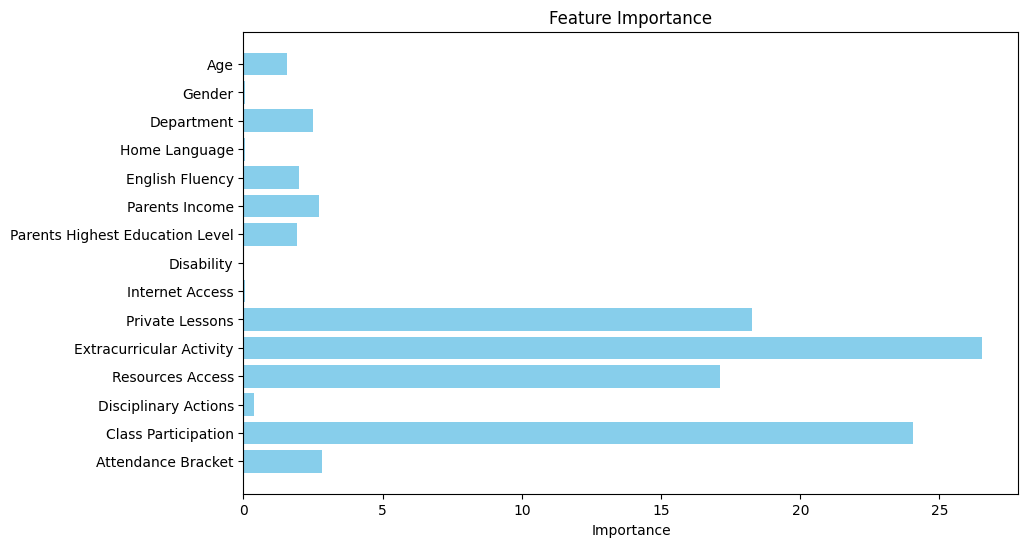

In [74]:
# Get the feature names.
feature_names = features.columns

# Create a bar plot.
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

###**Hyperparameter Tuning**

**Perform Randomized Search Hyperparameter tuning**

In [75]:
from scipy import stats

params_distribution = {
    'learning_rate': stats.uniform(0.005, 0.01),
    'depth': list(range(3, 10)),
    'l2_leaf_reg': stats.uniform(1, 10),
    'boosting_type': ['Ordered', 'Plain'],
}

random_search_model = CatBoostClassifier(random_seed=42)
random_search_result = random_search_model.randomized_search(
    params_distribution,
    train_pool,
    stratified=True,
    n_iter=20,
    verbose=5,
    partition_random_seed=123)

Streaming output truncated to the last 5000 lines.
25:	learn: 0.5290432	test: 0.5520780	best: 0.5520780 (25)	total: 136ms	remaining: 5.1s
26:	learn: 0.5232497	test: 0.5481369	best: 0.5481369 (26)	total: 141ms	remaining: 5.06s
27:	learn: 0.5182887	test: 0.5455233	best: 0.5455233 (27)	total: 147ms	remaining: 5.11s
28:	learn: 0.5137266	test: 0.5416942	best: 0.5416942 (28)	total: 151ms	remaining: 5.06s
29:	learn: 0.5086480	test: 0.5376370	best: 0.5376370 (29)	total: 154ms	remaining: 4.99s
30:	learn: 0.5026744	test: 0.5322833	best: 0.5322833 (30)	total: 161ms	remaining: 5.04s
31:	learn: 0.4969194	test: 0.5285309	best: 0.5285309 (31)	total: 168ms	remaining: 5.07s
32:	learn: 0.4899462	test: 0.5218358	best: 0.5218358 (32)	total: 174ms	remaining: 5.09s
33:	learn: 0.4859378	test: 0.5178203	best: 0.5178203 (33)	total: 177ms	remaining: 5.02s
34:	learn: 0.4836206	test: 0.5166000	best: 0.5166000 (34)	total: 179ms	remaining: 4.92s
35:	learn: 0.4801483	test: 0.5133001	best: 0.5133001 (35)	total: 181ms

In [76]:
print("Params:", random_search_result["params"])

Params: {'boosting_type': 'Ordered', 'depth': 5, 'learning_rate': 0.010812382214226122, 'l2_leaf_reg': 3.8863055324025577}


In [77]:
params = random_search_result["params"]

# Initialize CatBoost model with the found params.
model = CatBoostClassifier(**params)

# Fit the model.
model.fit(train_pool, eval_set=validation_pool, verbose=100)

0:	learn: 0.6840182	test: 0.6852695	best: 0.6852695 (0)	total: 6.49ms	remaining: 6.49s
100:	learn: 0.3924182	test: 0.4297725	best: 0.4297725 (100)	total: 764ms	remaining: 6.8s
200:	learn: 0.3186148	test: 0.3616860	best: 0.3616858 (199)	total: 1.52s	remaining: 6.07s
300:	learn: 0.2783637	test: 0.3314271	best: 0.3314271 (300)	total: 2.25s	remaining: 5.22s
400:	learn: 0.2459573	test: 0.3115023	best: 0.3114606 (393)	total: 3.02s	remaining: 4.52s
500:	learn: 0.2166163	test: 0.2890497	best: 0.2890497 (500)	total: 3.78s	remaining: 3.77s
600:	learn: 0.1908828	test: 0.2749529	best: 0.2749228 (598)	total: 5.28s	remaining: 3.5s
700:	learn: 0.1614412	test: 0.2576219	best: 0.2576219 (700)	total: 7.26s	remaining: 3.1s
800:	learn: 0.1388992	test: 0.2512081	best: 0.2511931 (798)	total: 8.46s	remaining: 2.1s
900:	learn: 0.1217064	test: 0.2457020	best: 0.2450223 (877)	total: 9.6s	remaining: 1.05s
999:	learn: 0.1096278	test: 0.2451523	best: 0.2448036 (979)	total: 10.7s	remaining: 0us

bestTest = 0.244803

In [78]:
# Make predictions for training and validation sets.
y_train_preds = model.predict(X_train)
y_val_preds = model.predict(X_validation)

# Get probability predictions for AUC calculation.
y_train_probs = model.predict_proba(X_train)[:, 1]
y_val_probs = model.predict_proba(X_validation)[:, 1]


# Calculate metrics for training data.
train_accuracy, train_precision, train_recall, train_f1, train_auc = calculate_metrics(y_train, y_train_preds, y_train_probs)

# Calculate metrics for validation data.
val_accuracy, val_precision, val_recall, val_f1, val_auc = calculate_metrics(y_validation, y_val_preds, y_val_probs)

# Print the training and validation metrics.
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.2f}, Precision: {train_precision:.2f}, Recall: {train_recall:.2f}, F1 Score: {train_f1:.2f}, AUC: {train_auc:.2f}")

print("\nValidation Metrics:")
print(f"Accuracy: {val_accuracy:.2f}, Precision: {val_precision:.2f}, Recall: {val_recall:.2f}, F1 Score: {val_f1:.2f}, AUC: {val_auc:.2f}")

Training Metrics:
Accuracy: 0.96, Precision: 0.94, Recall: 1.00, F1 Score: 0.97, AUC: 0.99

Validation Metrics:
Accuracy: 0.92, Precision: 0.89, Recall: 1.00, F1 Score: 0.94, AUC: 0.96


In [79]:
# Training confusion matrix.
train_conf_matrix = confusion_matrix(y_train, y_train_preds)
print("Training Confusion Matrix:")
print(train_conf_matrix)

# Validation confusion matrix.
val_conf_matrix = confusion_matrix(y_validation, y_val_preds)
print("Validation Confusion Matrix:")
print(val_conf_matrix)

Training Confusion Matrix:
[[ 71  10]
 [  0 159]]
Validation Confusion Matrix:
[[19  6]
 [ 0 50]]


**Perform Hyperparameter tuning Using Bayesian optimization.**

In [80]:
! pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.4 MB/s eta 0:00:00


In [86]:
print("Optuna Version: {}".format(optuna.__version__))

Optuna Version: 4.0.0


In [81]:
import optuna
from optuna.samplers import TPESampler
from catboost.utils import eval_metric

In [89]:
def objective(trial):
    # Define hyperparameters to optimize.
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.01),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
    }

    # Create and train the CatBoost model.
    model = CatBoostClassifier(**params, random_seed=66)

    # Fit the model.
    model.fit(train_pool, verbose=0, eval_set=validation_pool)

    # Get predictions on the validation set
    y_true = validation_pool.get_label()
    y_pred = model.predict(validation_pool)

    # Calculate precision.
    precision = precision_score(y_true, y_pred, average='binary')

    # Return precision score as the objective.
    return precision

model = CatBoostClassifier(**params, random_seed=66)
model.fit(train_pool, verbose=0, eval_set=validation_pool)

sampler = optuna.samplers.TPESampler(seed=66)

# Create a study.
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=30)

[I 2024-10-09 11:46:45,812] A new study created in memory with name: no-name-572c98b0-fa02-4b7e-96b3-221ac3c63534
[I 2024-10-09 11:46:53,279] Trial 0 finished with value: 0.9411764705882353 and parameters: {'learning_rate': 0.005771437890656379, 'depth': 4, 'l2_leaf_reg': 4.264169195591988, 'boosting_type': 'Ordered'}. Best is trial 0 with value: 0.9411764705882353.
[I 2024-10-09 11:47:08,201] Trial 1 finished with value: 0.9433962264150944 and parameters: {'learning_rate': 0.006256051917434968, 'depth': 9, 'l2_leaf_reg': 6.018567306061175, 'boosting_type': 'Ordered'}. Best is trial 1 with value: 0.9433962264150944.
[I 2024-10-09 11:47:28,670] Trial 2 finished with value: 0.9074074074074074 and parameters: {'learning_rate': 0.005435880018044791, 'depth': 9, 'l2_leaf_reg': 3.687765031108315, 'boosting_type': 'Plain'}. Best is trial 1 with value: 0.9433962264150944.
[I 2024-10-09 11:47:45,189] Trial 3 finished with value: 0.9433962264150944 and parameters: {'learning_rate': 0.00951744516

In [90]:
# Get the best params.
optuna_params = study.best_params

# Create a new CatBoostClassifier using the best hyperparameters from Optuna.
best_model = CatBoostClassifier(**optuna_params, random_seed=66)

# Fit the model to your training data.
best_model.fit(train_pool, verbose=100, eval_set=validation_pool)

0:	learn: 0.6881667	test: 0.6888495	best: 0.6888495 (0)	total: 9.89ms	remaining: 9.88s
100:	learn: 0.4671261	test: 0.4979533	best: 0.4979533 (100)	total: 1.56s	remaining: 13.9s
200:	learn: 0.3884448	test: 0.4238574	best: 0.4238574 (200)	total: 2.55s	remaining: 10.2s
300:	learn: 0.3414217	test: 0.3733771	best: 0.3733771 (300)	total: 3.52s	remaining: 8.17s
400:	learn: 0.3047637	test: 0.3362563	best: 0.3362563 (400)	total: 4.67s	remaining: 6.98s
500:	learn: 0.2824535	test: 0.3151822	best: 0.3151822 (500)	total: 5.98s	remaining: 5.95s
600:	learn: 0.2666885	test: 0.3016052	best: 0.3016052 (600)	total: 7.29s	remaining: 4.84s
700:	learn: 0.2496294	test: 0.2892992	best: 0.2891997 (699)	total: 8.68s	remaining: 3.7s
800:	learn: 0.2349435	test: 0.2789791	best: 0.2788728 (799)	total: 10.3s	remaining: 2.55s
900:	learn: 0.2213856	test: 0.2690916	best: 0.2690838 (899)	total: 12.3s	remaining: 1.35s
999:	learn: 0.2070547	test: 0.2583126	best: 0.2583126 (999)	total: 15.7s	remaining: 0us

bestTest = 0.25

In [91]:
# Make predictions for training and validation sets.
y_train_preds = best_model.predict(X_train)
y_val_preds = best_model.predict(X_validation)

# Get probability predictions for AUC calculation.
y_train_probs = best_model.predict_proba(X_train)[:, 1]
y_val_probs = best_model.predict_proba(X_validation)[:, 1]


# Calculate metrics for training data.
train_accuracy, train_precision, train_recall, train_f1, train_auc = calculate_metrics(y_train, y_train_preds, y_train_probs)

# Calculate metrics for validation data.
val_accuracy, val_precision, val_recall, val_f1, val_auc = calculate_metrics(y_validation, y_val_preds, y_val_probs)

# Print the training and validation metrics.
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.2f}, Precision: {train_precision:.2f}, Recall: {train_recall:.2f}, F1 Score: {train_f1:.2f}, AUC: {train_auc:.2f}")

print("\nValidation Metrics:")
print(f"Accuracy: {val_accuracy:.2f}, Precision: {val_precision:.2f}, Recall: {val_recall:.2f}, F1 Score: {val_f1:.2f}, AUC: {val_auc:.2f}")


# Training confusion matrix.
train_conf_matrix = confusion_matrix(y_train, y_train_preds)
print("Training Confusion Matrix:")
print(train_conf_matrix)

# Validation confusion matrix.
val_conf_matrix = confusion_matrix(y_validation, y_val_preds)
print("Validation Confusion Matrix:")
print(val_conf_matrix)

Training Metrics:
Accuracy: 0.97, Precision: 0.95, Recall: 1.00, F1 Score: 0.98, AUC: 0.99

Validation Metrics:
Accuracy: 0.96, Precision: 0.94, Recall: 1.00, F1 Score: 0.97, AUC: 0.96
Training Confusion Matrix:
[[ 73   8]
 [  0 159]]
Validation Confusion Matrix:
[[22  3]
 [ 0 50]]


Hyperparameter tuning using **Bayesian Optimization** via the **Optuna** library has produced a significant improvement in model performance. Optuna efficiently explores the hyperparameter space by focusing on promising areas, resulting in optimal parameter combinations. The tuned parameters were then used to build a more accurate and robust model, demonstrating the effectiveness of this approach in achieving superior results compared to traditional methods of tuning.

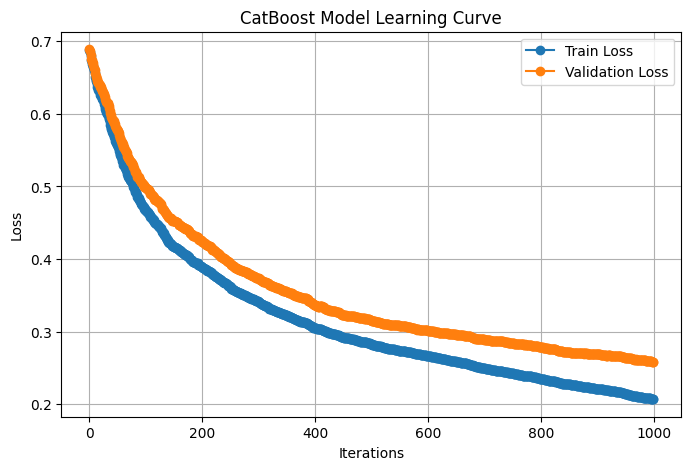

In [92]:
# Retrieve the evaluation results.
evals_result = best_model.get_evals_result()

# Extract train and validation loss over iterations.
train_loss = evals_result['learn']['Logloss']
val_loss = evals_result['validation']['Logloss']

# Plot the learning curve.
iterations = range(len(train_loss))
plt.figure(figsize=(8, 5))
plt.plot(iterations, train_loss, label="Train Loss", marker='o')
plt.plot(iterations, val_loss, label="Validation Loss", marker='o')

# Add title and labels.
plt.title("CatBoost Model Learning Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

# Show grid.
plt.grid(True)

# Display the plot.
plt.show()

In [93]:
# Get model parameters.
params = best_model.get_params()
print("Model Parameters:")
print(params, "\n")

# Get feature importance.
feature_importance = best_model.get_feature_importance()
print("Feature Importance:")
print(feature_importance, "\n")

# Get the best score.
best_score = model.get_best_score()
print("Best Score:", best_score)

Model Parameters:
{'learning_rate': 0.006256051917434968, 'depth': 9, 'l2_leaf_reg': 6.018567306061175, 'random_seed': 66, 'boosting_type': 'Ordered'} 

Feature Importance:
[3.84153585e-01 1.95324955e-02 1.36338251e+00 2.62993927e-01
 1.57721440e+00 1.04721185e+00 2.37782372e+00 1.15600832e-02
 1.03650265e-01 1.50689056e+01 3.30894959e+01 1.69776291e+01
 0.00000000e+00 2.64405390e+01 1.27590752e+00] 

Best Score: {'learn': {'Logloss': 0.11923208667102017}, 'validation': {'Logloss': 0.2032284991180473}}


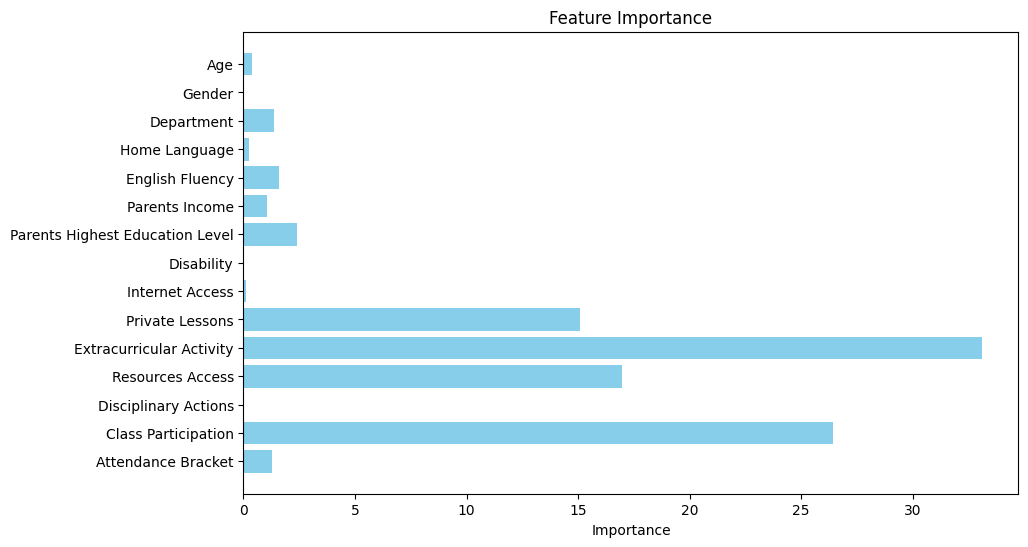

In [94]:
# Get the feature names.
feature_names = features.columns

# Create a bar plot.
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

### **Use the Model for Inference**


In [95]:
# Get predicted values.
y_pred = best_model.predict(features)

# Create a result DataFrame.
results_df = pd.DataFrame({
    'True Predictions': target.values.flatten(),
    'Predicted Values': y_pred
})

# Display the result DataFrame.
results_df.head(10)

,True Predictions,Predicted Values
0,0,0
1,1,1
2,1,1
3,0,0
4,1,1
5,1,1
6,0,0
7,1,1
8,1,1
9,1,1


### **Save the Model**

In [96]:
from google.colab import drive

# Mount Google Drive.
drive.mount('/content/drive')

# Define the path where you want to save the model.
model_save_path = '/content/drive/My Drive/catboost_model.cbm'

# Save the trained model to the specified path.
model.save_model(model_save_path)

# Print confirmation that the model has been saved successfully!
print(f"Model saved successfully at: {model_save_path}")

Mounted at /content/drive
Model saved successfully at: /content/drive/My Drive/catboost_model.cbm


### **Load the Model for Inference**

In [97]:
# Create a new instance of the CatBoost model.
print("Creating a new instance of the CatBoost model...")
loaded_model = CatBoostClassifier()

# Load the saved CatBoost model from the specified path.
print(f"Loading the saved model from: {model_save_path}...")
loaded_model.load_model(model_save_path)

# Confirm that the model has been loaded successfully.
print("The saved model has been loaded successfully!")

Creating a new instance of the CatBoost model...
Loading the saved model from: /content/drive/My Drive/catboost_model.cbm...
The saved model has been loaded successfully!


In [98]:
# Get predicted values.
y_pred = loaded_model.predict(features)

# Create a result DataFrame.
results_df = pd.DataFrame({
    'True Predictions': target.values.flatten(),
    'Predicted Values': y_pred
})

# Display the result DataFrame.
results_df.head(10)

,True Predictions,Predicted Values
0,0,0
1,1,1
2,1,1
3,0,0
4,1,1
5,1,1
6,0,0
7,1,1
8,1,1
9,1,1


In [101]:
! pip install shap -q

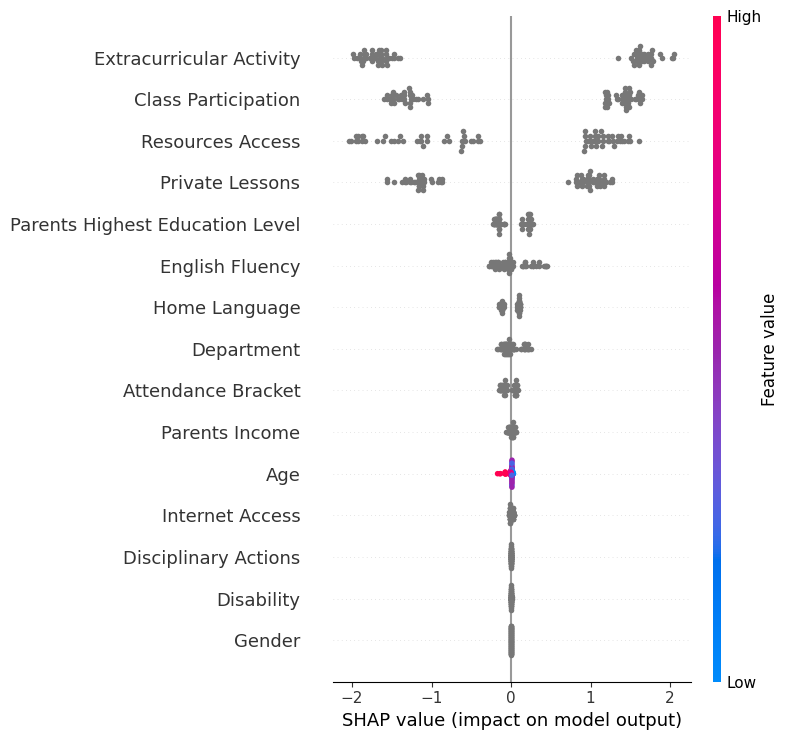

In [102]:
import shap

# Initialize SHAP explainer for CatBoost
explainer = shap.TreeExplainer(loaded_model)

# Compute SHAP values
shap_values = explainer.shap_values(X_validation)

# Plot summary of SHAP values
shap.summary_plot(shap_values, X_validation)


In [104]:
explainer = shap.TreeExplainer(loaded_model)

# Select one instance from your test data (e.g., the first row)
single_instance = X_validation.iloc[0:1]  # Select a single row for explanation

# Compute SHAP values for that single instance
shap_values_single = explainer.shap_values(single_instance)

print(shap_values_single)

[[-1.32887120e-01  0.00000000e+00 -9.16284844e-02  1.10341654e-01
  -5.66357146e-02  1.48475710e-02 -1.53399215e-01 -3.74508091e-04
  -1.44292176e-02  1.16547845e+00 -1.66730167e+00 -1.60592352e+00
   1.46110324e-03  1.45095397e+00 -7.80862481e-02]]


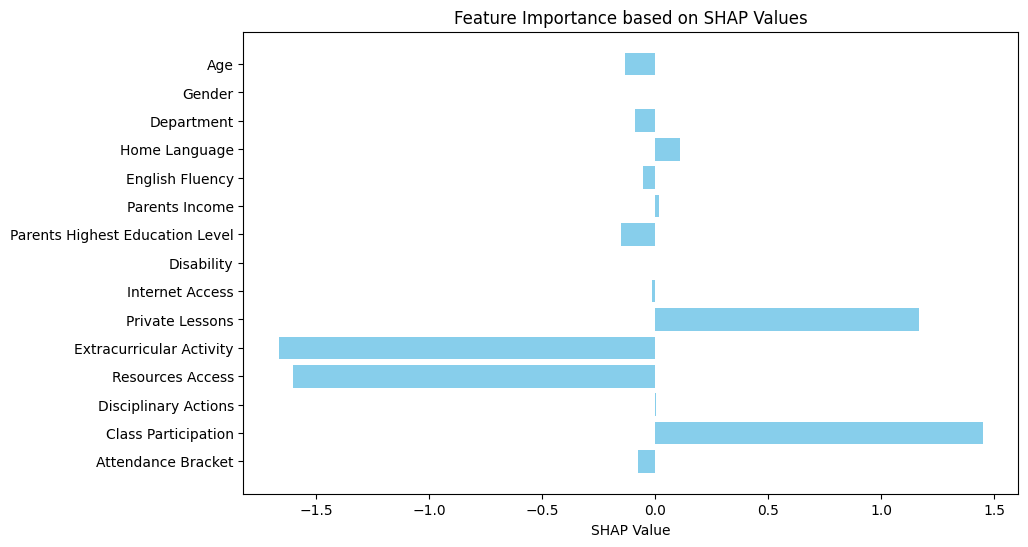

In [112]:
# Create a bar chart
feature_names = X_validation.columns  # Assuming X_validation is a DataFrame
plt.figure(figsize=(10, 6))
plt.barh(feature_names, shap_values[0], color='skyblue')
plt.xlabel('SHAP Value')
plt.title('Feature Importance based on SHAP Values')
plt.gca().invert_yaxis()  # Invert y axis to have the highest values at the top
plt.show()